# <b> Time Series Analysis for Climate Change in New Delhi </b>

## <b> Importing libraries </b>

In [410]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_predict, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA

import warnings

## <b> Loading datasets </b>

In [411]:
df = pd.read_csv('./assets//DailyDelhiClimate.csv')
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


## <b> Exploratory analysis </b>

In [412]:
df.dtypes

date             object
meantemp        float64
humidity        float64
wind_speed      float64
meanpressure    float64
dtype: object

In [413]:
# Changing date column to datetime and adding new colummns

df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)

df["month"] = df.index.month
df["year"] = df.index.year
df["difftemp"] = df["meantemp"].diff()

In [414]:
df.head()

,meantemp,humidity,wind_speed,meanpressure,month,year,difftemp
date,,,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,1,2013,NaN
2013-01-02,7.400000,92.000000,2.980000,1017.800000,1,2013,-2.600000
2013-01-03,7.166667,87.000000,4.633333,1018.666667,1,2013,-0.233333
2013-01-04,8.666667,71.333333,1.233333,1017.166667,1,2013,1.500000
2013-01-05,6.000000,86.833333,3.700000,1016.500000,1,2013,-2.666667


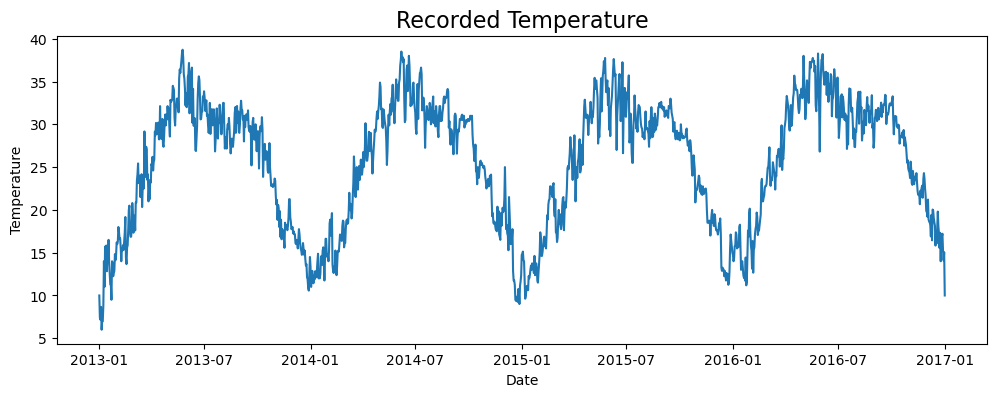

In [415]:
# Temperature per day

f = plt.figure(figsize=(12,4))

ax = f.add_subplot(111)
sns.lineplot(data=df, x="date", y="meantemp")
plt.title("Recorded Temperature", fontsize=16)
plt.ylabel("Temperature")
plt.xlabel("Date")

plt.show()

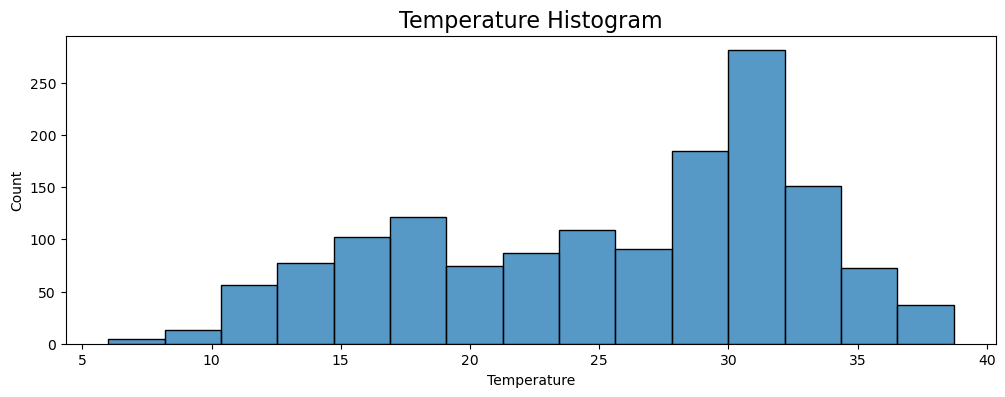

In [416]:
# Temperature distribution

f = plt.figure(figsize=(12,4))

ax = f.add_subplot(111)
sns.histplot(df["meantemp"])
plt.title("Temperature Histogram", fontsize=16)
plt.ylabel("Count")
plt.xlabel("Temperature")

plt.show()

OBS: Temperature follows a left skewed distribution

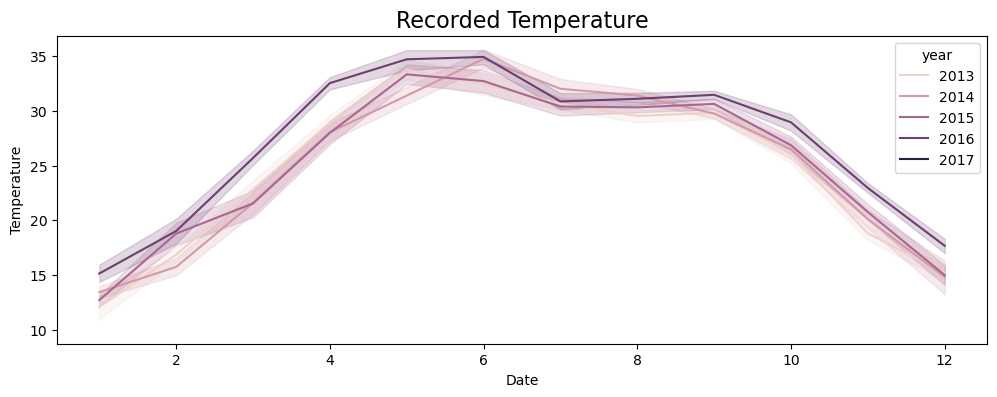

In [417]:
f = plt.figure(figsize=(12,4))

ax = f.add_subplot(111)
sns.lineplot(data=df, x="month", y="meantemp", hue="year")
plt.title("Recorded Temperature", fontsize=16)
plt.ylabel("Temperature")
plt.xlabel("Date")

plt.show()

OBS: Clear seasonality, all years follow the same trend.  
OBS: Highest mean temperature is in the last year.

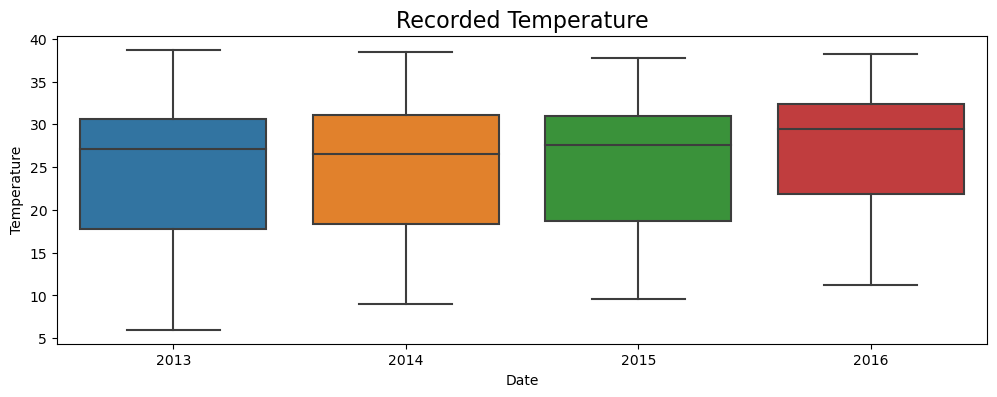

In [418]:
f = plt.figure(figsize=(12,4))

ax = f.add_subplot(111)
sns.boxplot(data=df.iloc[:-1], x="year", y="meantemp")
plt.title("Recorded Temperature", fontsize=16)
plt.ylabel("Temperature")
plt.xlabel("Date")

plt.show()

OBS: Similar averages for the first 3 years. 2016 temperatures are higher overall.

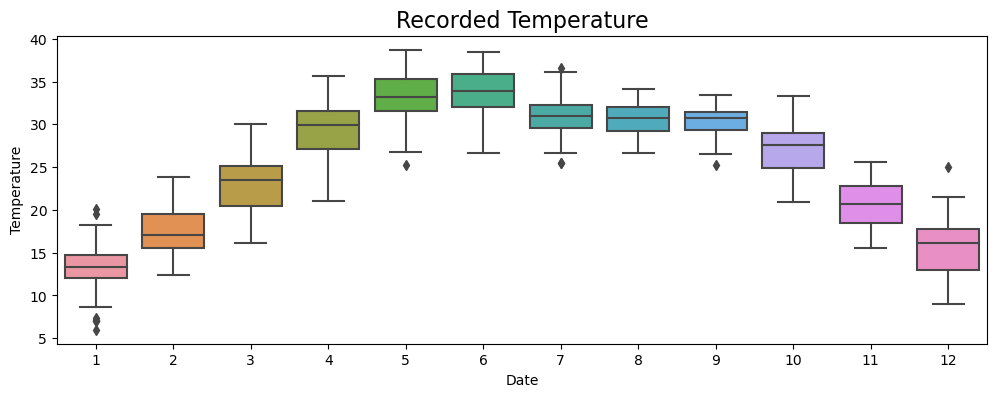

In [419]:
f = plt.figure(figsize=(12,4))

ax = f.add_subplot(111)
sns.boxplot(data=df.iloc[:-1], x="month", y="meantemp")
plt.title("Recorded Temperature", fontsize=16)
plt.ylabel("Temperature")
plt.xlabel("Date")

plt.show()

OBS: Higher temperatures in the middle of the year.

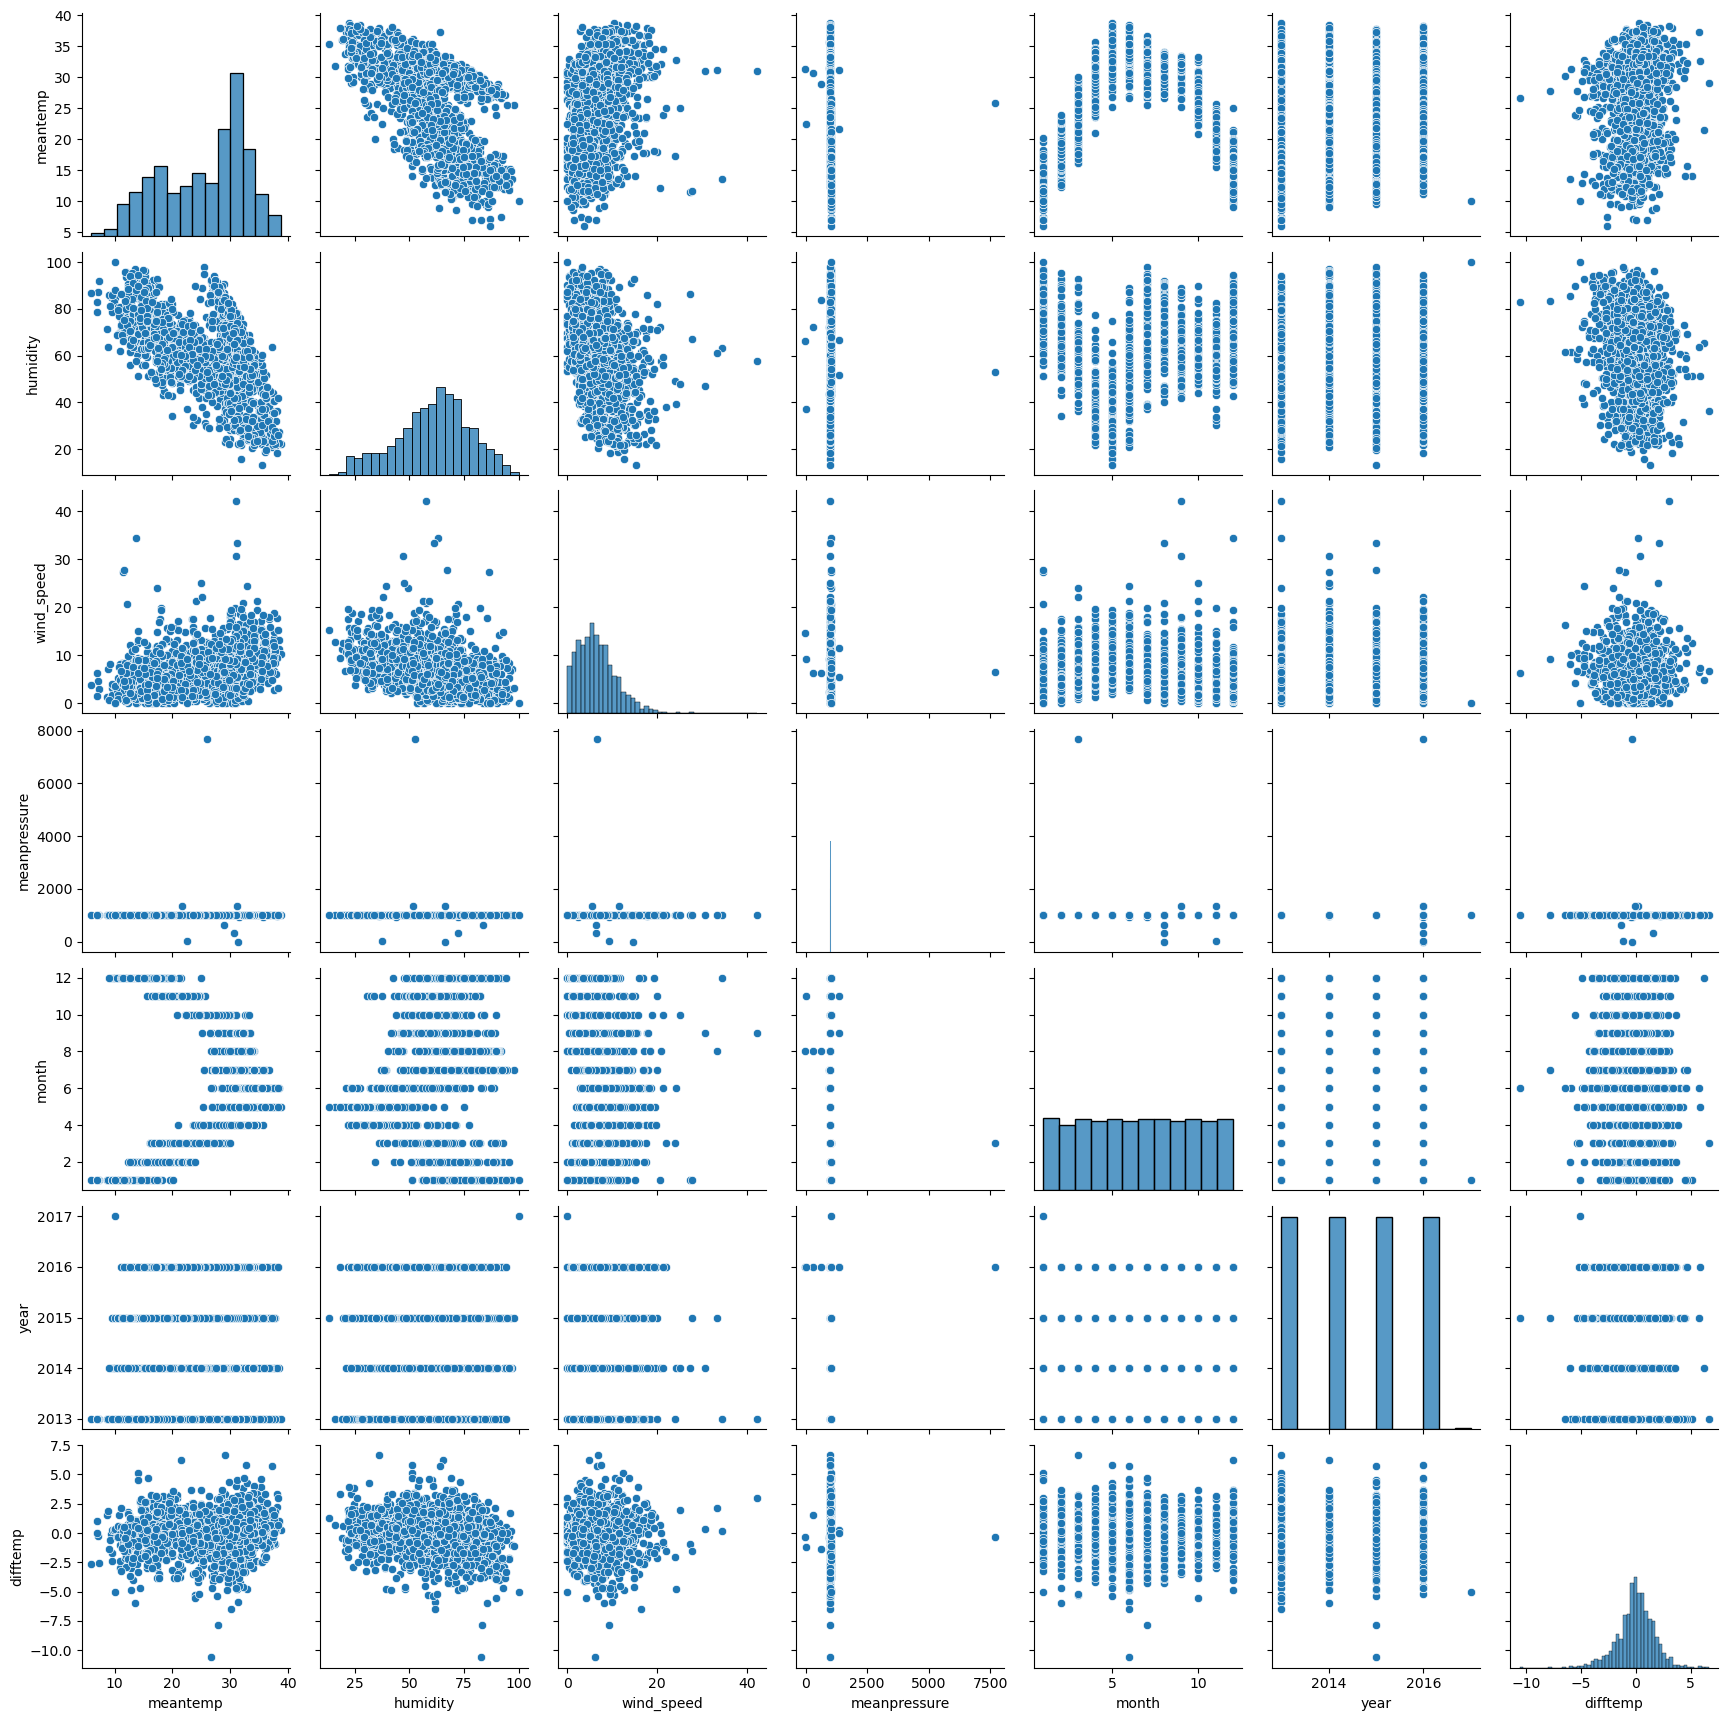

In [423]:
sns.pairplot(df)

In [424]:
# Tests for Stationarity - N0 KPSS: Data is stationary | N0 ADF: Data has a unit-root

warnings.filterwarnings('ignore')
kpss_test = kpss(df["meantemp"], 'ct')
adf_test = adfuller(df["meantemp"])

if kpss_test[1] > 0.05 and adf_test[1] > 0.05: print('Data do not give enough observations. Can not say it is stationary or not.')
elif kpss_test[1] <= 0.05 and adf_test[1] > 0.05: print('Data is not stationary')
elif kpss_test[1] > 0.05 and adf_test[1] <= 0.05: print('Data is stationary')
else: print('Data do not give enough observations.')

Data do not give enough observations. Can not say it is stationary or not.


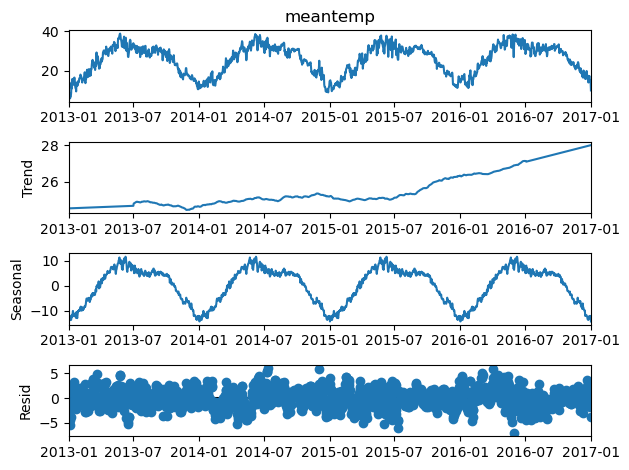

In [425]:
# Additive Decomposition - Because trend is not exponential

df_decomp = seasonal_decompose(df["meantemp"], model='additive', extrapolate_trend='freq', period=365)
df_decomp.plot()
plt.show()

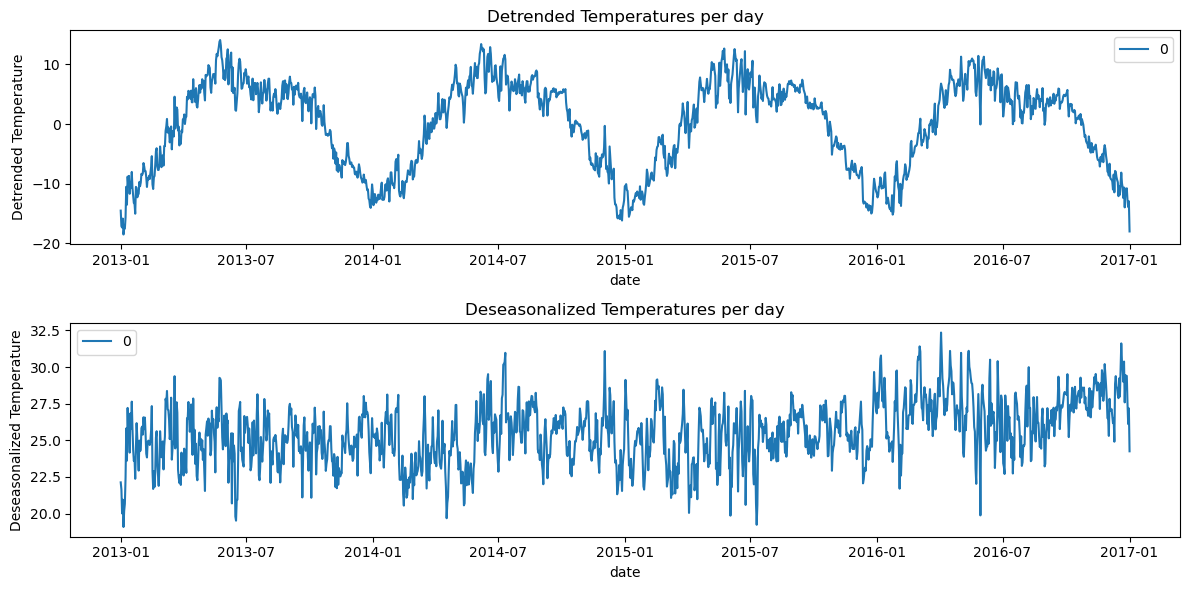

In [426]:
# Detrended temperature plot

f = plt.figure(figsize=(12, 6))

ax1 = f.add_subplot(211)
sns.lineplot(data=pd.DataFrame(df_decomp.observed - df_decomp.trend), ax=ax1)
ax1.set_ylabel('Detrended Temperature')
ax1.set_title('Detrended Temperatures per day')

ax2 = f.add_subplot(212)
sns.lineplot(data=pd.DataFrame(df_decomp.observed - df_decomp.seasonal), ax=ax2)
ax2.set_ylabel('Deseasonalized Temperature')
ax2.set_title('Deseasonalized Temperatures per day')

plt.tight_layout()
plt.show()

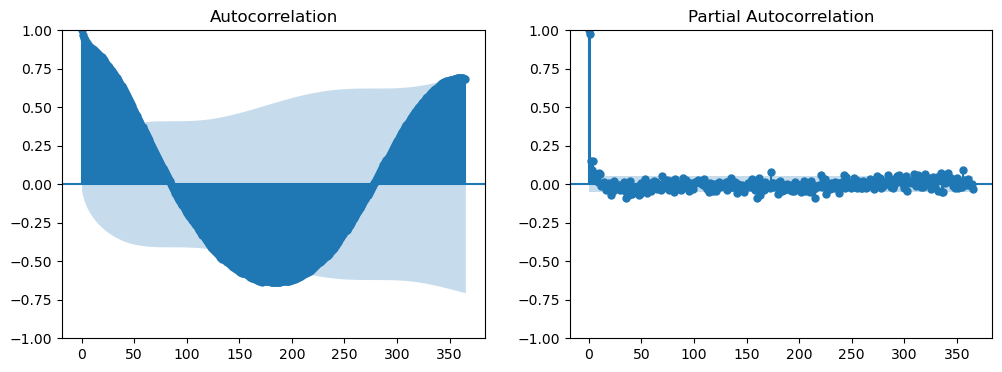

In [427]:
# Order of the AR and MA models

f = plt.figure(figsize=(12, 4))

ax1 = f.add_subplot(121)
plot_acf(df["meantemp"], lags=365, ax=ax1)

ax2 = f.add_subplot(122)
plot_pacf(df["meantemp"], lags=365, method='ols', ax=ax2)

plt.show()

OBS: There are several autocorrelations that are significantly non-zero. Therefore, the time series is non-random.

In [428]:
# Test for Stationarity for lags

warnings.filterwarnings('ignore')
kpss_test = kpss(df["difftemp"].dropna(), 'ct')
adf_test = adfuller(df["difftemp"].dropna())

if kpss_test[1] > 0.05 and adf_test[1] > 0.05: print('Data do not give enough observations. Can not say it is stationary or not.')
elif kpss_test[1] <= 0.05 and adf_test[1] > 0.05: print('Data is not stationary')
elif kpss_test[1] > 0.05 and adf_test[1] <= 0.05: print('Data is stationary')
else: print('Data do not give enough observations.')

Data is stationary


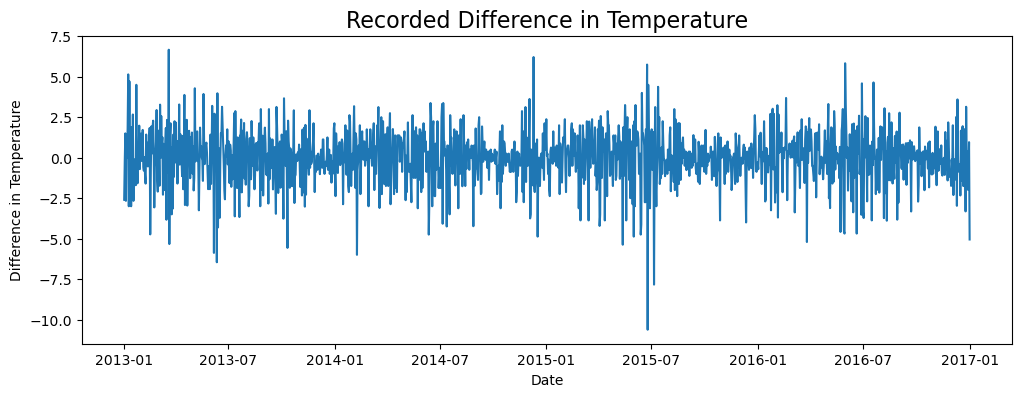

In [429]:
f = plt.figure(figsize=(12,4))

ax = f.add_subplot(111)
sns.lineplot(data=df.dropna(), x='date', y='difftemp')
plt.title("Recorded Difference in Temperature", fontsize=16)
plt.ylabel("Difference in Temperature")
plt.xlabel("Date")

plt.show()

In [430]:
df["diff_temp"].describe()

KeyError: 'diff_temp'

OBS: Values oscilating close to 0. Mean equals to 0.

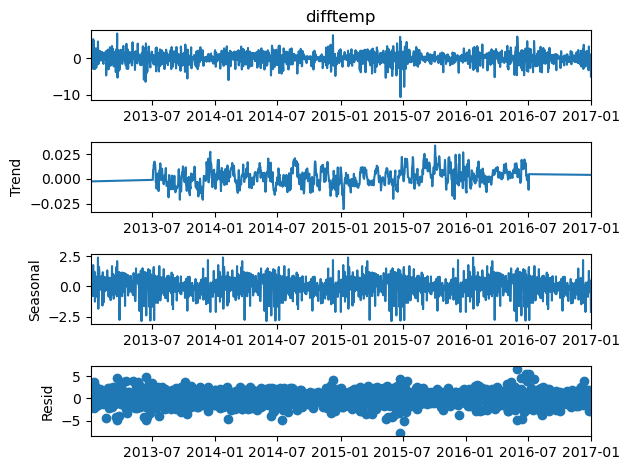

In [ ]:
# Additive Decomposition

decomp_add = seasonal_decompose(df['difftemp'].dropna(), model='additive', extrapolate_trend='freq', period=365)
decomp_add.plot()
plt.show()

## <b> Model Training </b>

In [ ]:
arima_model = ARIMA(df["meantemp"][:'2016-03-01'], order=(1,1,1))
model = arima_model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               meantemp   No. Observations:                 1156
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2190.867
Date:                Mon, 03 Apr 2023   AIC                           4387.734
Time:                        22:01:02   BIC                           4402.890
Sample:                    01-01-2013   HQIC                          4393.454
                         - 03-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5742      0.053     10.831      0.000       0.470       0.678
ma.L1         -0.7961      0.043    -18.653      0.000      -0.880      -0.712
sigma2         2.6004      0.080     32.690      0.000       2.445       2.756
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               253.78
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -0.47
Prob(H) (two-sided):                  0.80   Kurtosis:                         5.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

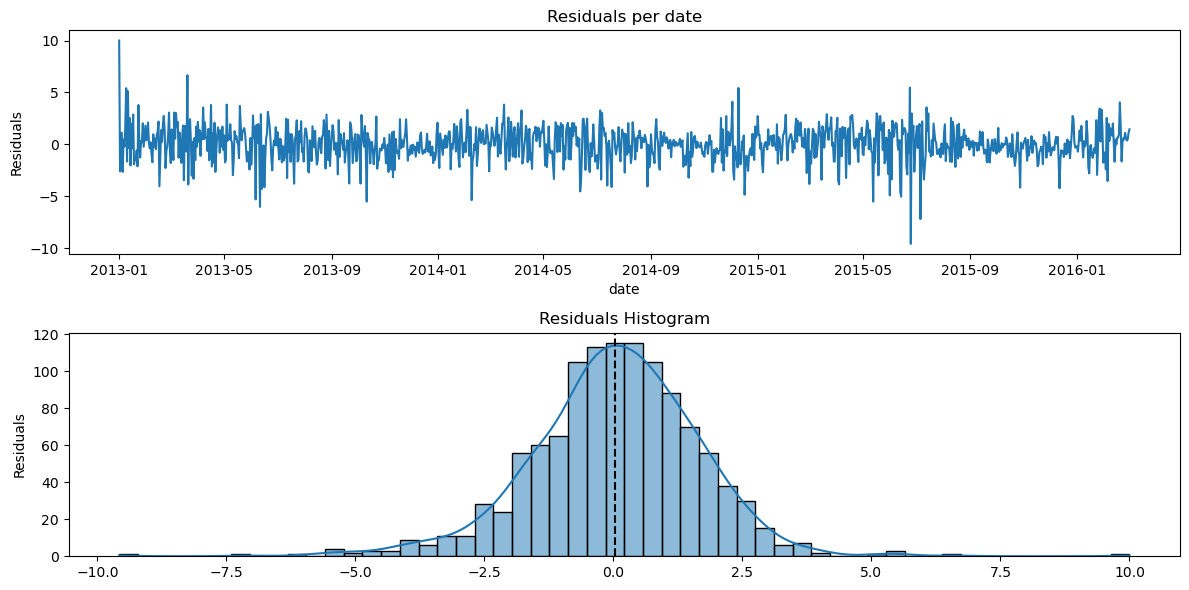

In [ ]:
# Plotting the residuals

f = plt.figure(figsize=(12, 6))

ax1 = f.add_subplot(211)
sns.lineplot(model.resid, ax=ax1)
plt.ylabel('Residuals')
ax1.set_title('Residuals per date')

ax2 = f.add_subplot(212)
sns.histplot(model.resid, kde=True, ax=ax2)
ax2.axvline(model.resid.mean(), color='k',linestyle='--')
plt.ylabel('Residuals')
ax2.set_title('Residuals Histogram')

plt.tight_layout()
plt.show()

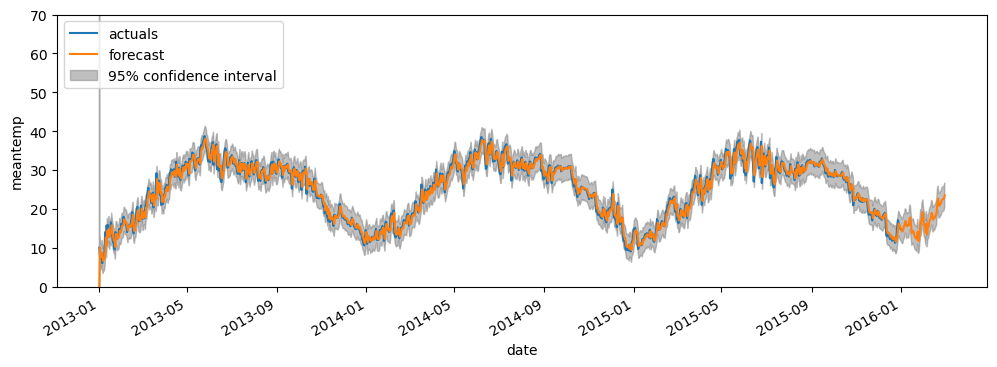

In [ ]:
# Plot predictions

f = plt.figure(figsize=(12, 4))

ax = f.add_subplot(111)
ax.set_ylim([0, 70])
sns.lineplot(data=df[:'2016-01-01'], x="date", y="meantemp", ax=ax, label='actuals')
plot_predict(model, ax=ax)
plt.legend(loc='upper left')

plt.show()

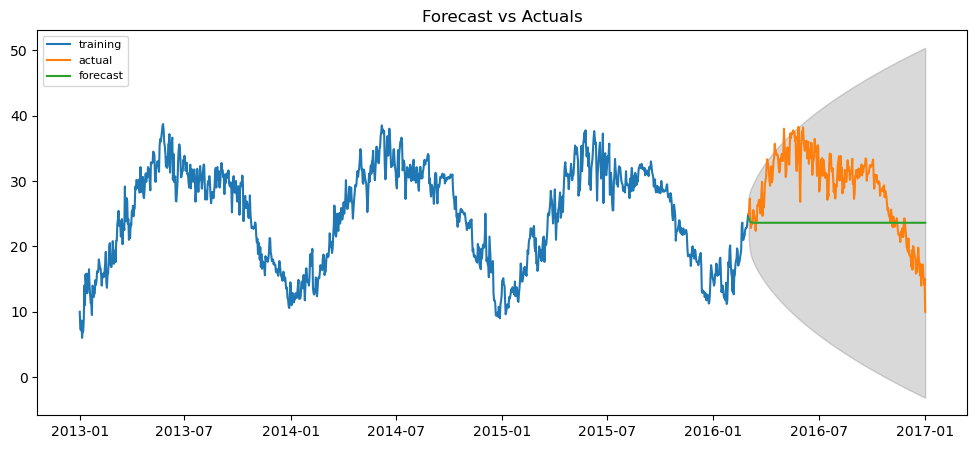

In [ ]:
train = df['meantemp'][:'2016-03-01']
test = df['meantemp']['2016-03-01':]

forecast = model.get_forecast(df.index.max())
confidence_interval = forecast.conf_int(alpha=0.05) # 95% confidence

fc_series = pd.Series(forecast.predicted_mean)
lower_series = pd.Series(confidence_interval.iloc[:, 0])
upper_series = pd.Series(confidence_interval.iloc[:, 1])


plt.figure(figsize=(12,5))
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## <b> Anomaly Detection </b>

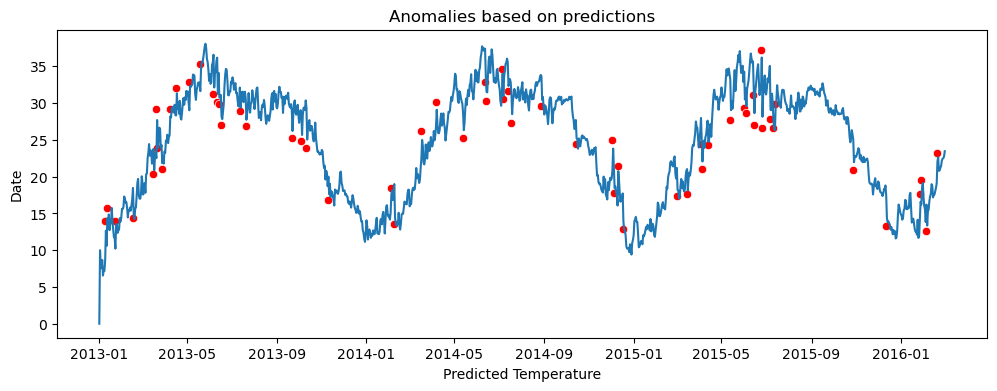

In [408]:
predictions = model.get_prediction().predicted_mean
pred_ci = model.get_prediction().conf_int(alpha=0.05)
pred_ci["actual_temp"] = df["meantemp"]
pred_ci["anomaly"] = np.where((pred_ci["actual_temp"] > pred_ci["upper meantemp"]) | (pred_ci["actual_temp"] < pred_ci["lower meantemp"]), 1, 0)

f = plt.figure(figsize=(12, 4))

ax = f.add_subplot(111)
sns.lineplot(predictions, ax=ax)
sns.scatterplot(pred_ci[pred_ci["anomaly"] == 1]["actual_temp"], color='r', ax=ax)
plt.xlabel('Predicted Temperature')
plt.ylabel('Date')
ax.set_title('Anomalies based on predictions')


plt.show()